#Lecture 10: 2D Convolutional Networks and LSTM

Here we are going to show how to use a recurrent neural network combined with a convolution.  The first model is going to try to predict pixels in the image from pixels in previous images.  Because the image sequence is moving, the prediction will be based on a 5x5 region in the prior image, and because we will assume the rule for prediction for all pixels (given the pixels around it) is the same, this is a convolution, so we need to combine a convolutional NN with a recurrent NN.  There are a number of ways to do this, but here we will use the built-in Keras layer ConvLSTM2D().  

The first step is to understand what an LSTM() layer is.  Remember that SimpleRNN takes an input $x(t)$ and a hidden state $h(t)$ at each time step and produces an output $h(t+1)$.  The relationships are:
\begin{equation}
  h(t+1) = \sigma (W_x x(t) + W_h h(t))
\end{equation}
where $W_x$ and $W_h$ are the weight matrices from $x$ and $h$ respectively.  If we did not have the nonlinearity $\sigma$, then this would be the linear system:
\begin{equation}
  h(t+1) = A h(t) + B x(t)
\end{equation}

One problem that occurs with this structure, is that we often provide the training output only for the last time step $h(t_{final})$, and the error $\delta(t_{final}) = h(t_{final})- \hat{h}(t_{final})$ propagates backward through the network.  Each time the error propagates backward it goes through the matrix $W_h^T$ and then $d \sigma / dh$ on its way to the next layer, and thus even for a linear network the error propagated back to timestep $t$ looks like
\begin{equation}
  \delta(t) \approx (W_h^T)^{(t_{final}-t)} \delta(t_{final})
\end{equation}
For stable systems, the maximum eigenvalue $\lambda_{max}[W_h]<1$, so as we propagate backward in time, the magnitude of $\delta$ decreases as $\lambda_{max}^{(t_{final}-t)}$ which means it goes to zero.

Therefore earlier values of $h$ and $x$ have much less effect on the final result.  For many situations this is fine, and it is characteristic of finite-state Markov processes.  But in many NN applications (particularly natural language processing) there may be values early on that affect later processing.  For instance, in the sentence:   "It is not true that wherever in the world you have decided for whatever reason to travel, the exit from the museum will not pass through the gift shop."  The meaning of this sentence requires remembering the first "not"; if that piece of input data were lost in the backpropagation, there would be no effective way to make an appropriate interpretation.  This is less true for many signal-processing applications.

Nevertheless, it has led to the common usage of LSTM() rather than SimpleRNN() when doing timeseries data.  For instance, there is no ConvSimpleRNN2D() layer in Keras, while there is a ConvLSTM2D() layer.   You could write your own, but it's easier just to use LSTM and hope for the best.

So what is an LSTM()?  The acronym is long short-term memory.  It is basically a mixed-rate model that has two hidden states, a short-term hidden state $h(t)$ and a long-term hidden state $c(t)$.  There are several tunable parameters in the model, corresponding to:
1. how do the  short-term state and input affect the long-term state
2. how does the current long-term state affect the short-term state
3. when do we want to forget the long-term state and start over



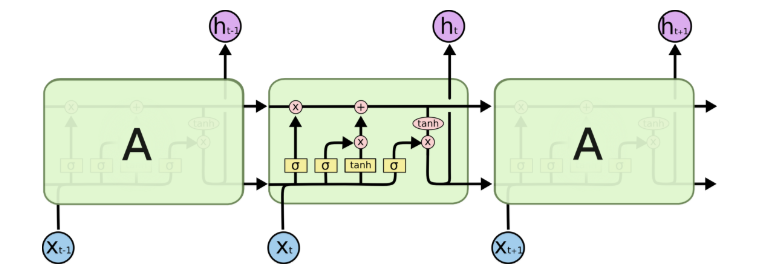

(picture from Alexandre Xavier)

Now the next thing we have to do is to put this into a convolutional network. What that means is that we want the dynamics to occur at each point in the image, but we want the *same* dynamics at each point in the image.  So in order to do that, the $W_h$ and $W_x$ matrices (and the $W_{ch}$, $W_{c}$, and $W_{hc}$ matrices) will be the same at each point in the image and will only apply to a small (eg. 5x5) region of each image.  This means that every matrix *within* the LSTM is constrained to be a convolution (ie: Toeplitz, as we discussed last class).  

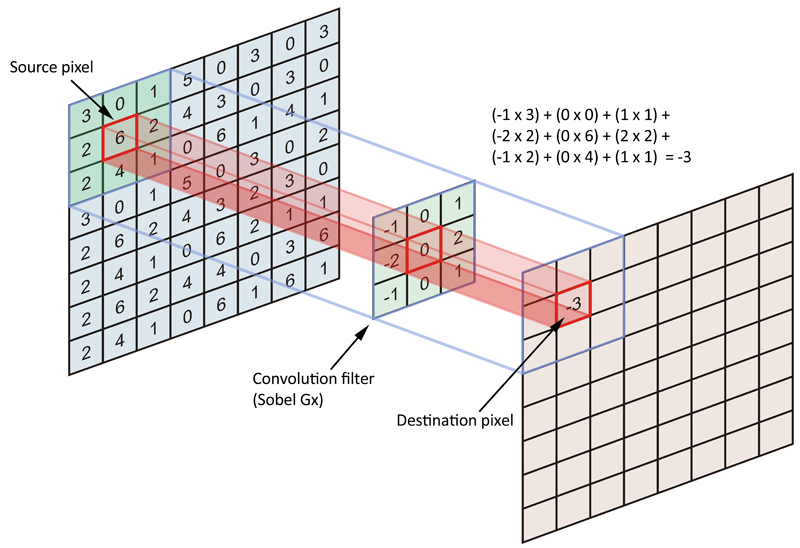

The above is a picture of a convolutional network. You know this by now, but it is helpful to remember what a convolution looks like in 2D.

The next step is to put the convolution into the LSTM network.  The way to think about this is that the individual matrices in the LSTM network are themselves convolution matrices.  Here is another picture from Xavier:

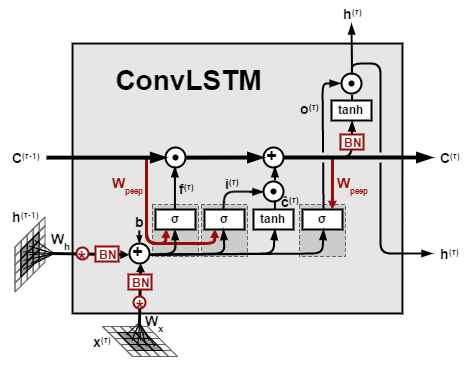

What is the point of all this?  It allows us to look at the dynamics of pixels in the image.  How do pixels change with time. Once we have set up the overall structure, the rest of the network is the same thing as before.

In [1]:
#The usual preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import cv2
from moviepy.editor import *


import seaborn as sns
import tensorflow as tf

#for your homework
np.random.seed(10327798)
tf.random.set_seed(10327798)


Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2572288/45929032 bytes (5.6%)5668864/45929032 bytes (12.3%)8732672/45929032 bytes (19.0%)11935744/45929032 bytes (26.0%)14991360/45929032 bytes (32.6%)18219008/45929032 bytes (39.7%)21454848/45929032 bytes (46.7%)24092672/45929032 bytes (52.5%)27418624/45929032 bytes (59.7%)29630464/45929032 bytes (64.5%)31711232/45929032 bytes (69.0%)33832960/45929032 bytes (73.7%)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#CHOC Childrens video from last time
video_filename = '/content/drive/MyDrive/Colab Notebooks/CHOCVideo2.mov'
video_reader = cv2.VideoCapture(video_filename)


Width = 640, Height = 360, Colors = 3


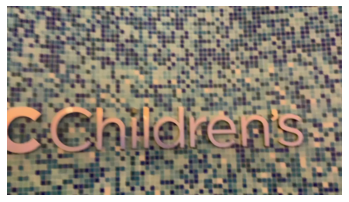

In [4]:
_, bgr_frame = video_reader.read()
rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)  #convert to RGB order for processing
plt.imshow(rgb_frame)
plt.axis('off')
orig_width = bgr_frame.shape[1]
orig_height = bgr_frame.shape[0]
ncolors = bgr_frame.shape[2]
image_width = 128
image_height = np.int(orig_height * image_width / orig_width)  #proportional scaling to preserve aspect ratio
print(f'Width = {orig_width}, Height = {orig_height}, Colors = {ncolors}')


In [5]:
#this time we are going to convert to grayscale, and we will only use one image at a time
#  we do not need to concatenate x(t) and x(t+1) because we will let the LSTM network handle the changes with time.
frames_list = []
nframes = 0
cvt_gray = [0.2989, 0.5870, 0.1140]   # these are standard ratios for converting RGB to grayscale

while True:
  success, bgr_frame = video_reader.read()
  if not success:
     break
  rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)   #RGB color conversion
  gray_frame = np.dot(rgb_frame, cvt_gray)  #dot() operator works on the last dimension
  resized_frame = cv2.resize(gray_frame, (image_width, image_height))  #resize and smooth to make smaller
  normalized_frame = resized_frame / 255
  frames_list.append(normalized_frame)
  nframes +=1
video_reader.release()
print(f'Read {nframes} frames')


Read 1844 frames


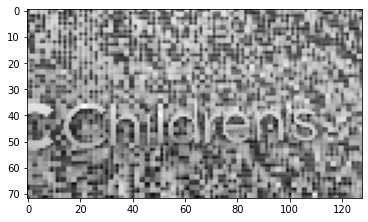

In [6]:
plt.imshow(frames_list[1], cmap=plt.get_cmap('gray'));

In [7]:
#same gyro data as before
dfGyro = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/gyro.csv')
dfGyro = dfGyro.rename(columns={
    'Time' : 't',
    ' Rotation Rate (X)' : 'wx', 
    ' Rotation Rate (Y)' : "wy", 
    ' Rotation Rate (Z)' : "wz"})   #data record at 30Hz, which is same as video frame rate
dfGyro['t'] = dfGyro['t'] - dfGyro['t'][0]  #set the initial time to be zero
dfGyro

,t,wx,wy,wz
0,0.00000,0.099509,-0.028426,-0.044815
1,0.03334,-0.003392,0.011171,-0.077364
2,0.06667,0.095900,-0.036499,-0.057394
3,0.10000,0.339899,-0.068623,0.027582
4,0.13334,0.290086,0.027662,0.018464
...,...,...,...,...
1832,61.05606,0.019010,0.038634,-0.068281
1833,61.08941,0.092307,-0.020316,0.006578
1834,61.12276,0.033317,-0.014301,0.038383
1835,61.15614,-0.001969,-0.004178,-0.023021


(1837, 2)

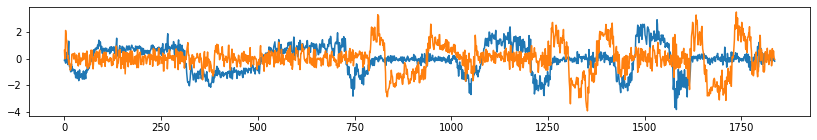

In [8]:
#predict both the horizontal and vertical gyro
desired_output_horizontal = dfGyro['wy'] / dfGyro['wy'].std()   #normalize so the network can learn
desired_output_vertical = dfGyro['wx'] / dfGyro['wx'].std()
desired_output = np.vstack((desired_output_horizontal.values, desired_output_vertical.values)).transpose()  #make column-wise

#make a list of the video frames that has the timestamps
nTimes, nOutputs = desired_output.shape  #in this case, the gyro data is slightly shorter than the video data
frames_list = frames_list[:nTimes]       #trim the video to be exactly the length of the gyro
      #to be safe, I checked first that the video length and gyro data length were the same; never trust the stated frame rate
imSeries = pd.Series(data=frames_list, index=dfGyro['t'])   #assigns timestamps to the video data in case we need that

plt.figure(figsize=(14,2))
plt.plot(desired_output);   #the gyro data are quite noisy.  I don't both filtering it; the network has to figure this out.
desired_output.shape


In [9]:
from tensorflow.python.keras.engine.base_layer_utils import uses_keras_history
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Permute, AveragePooling2D, Concatenate
from tensorflow.keras.layers import Dense, Flatten, Reshape, Conv2D, LayerNormalization, SimpleRNN
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D, ConvLSTM2D, LSTM, Input
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping


#Model1: image prediction
The first task will be to predict the image at time $t$ from the images at times $t-1 \ldots t-5$.  Each pixel in $x(t)$ likely depends mostly on the immediately surrounding pixels in recent time points, so we can use a convolutional network with a 5x5 region to do this.  But the convolutional network is part of the LSTM unit so that it can look at the changes with time.  Input will be frames_list, and output will also be frames_list, but as you recall, TimeSeriesGenerator automatically chooses $frames\_list[t]$ as the output and  $(frames\_list[t-5],\ldots, frames\_list[t-1])$ as input.

In [150]:
#generator for image prediction
early_stop = EarlyStopping(monitor='val_loss',patience=2)

predict_length = 5
batch_size = 1
training_set_size = np.int(0.9 * nTimes)
test_set_size = nTimes - training_set_size
gen1 = TimeseriesGenerator(frames_list, frames_list, length = predict_length, batch_size=batch_size)
training_gen1 = TimeseriesGenerator(frames_list[:training_set_size], frames_list[:training_set_size], length = predict_length, batch_size=batch_size)
validation_gen1 = TimeseriesGenerator(frames_list[:-test_set_size], frames_list[:-test_set_size], length = predict_length, batch_size=batch_size)

#note the shape of the output:  (batch_size, predict_length, height, width, colorchannels)
gen1[100][0].shape

(1, 5, 72, 128)

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 5, 72, 128, 1)]   0         
                                                                 
 conv_lstm2d_21 (ConvLSTM2D)  (None, 72, 128, 10)      11040     
                                                                 
 dense_16 (Dense)            (None, 72, 128, 1)        11        
                                                                 
Total params: 11,051
Trainable params: 11,051
Non-trainable params: 0
_________________________________________________________________


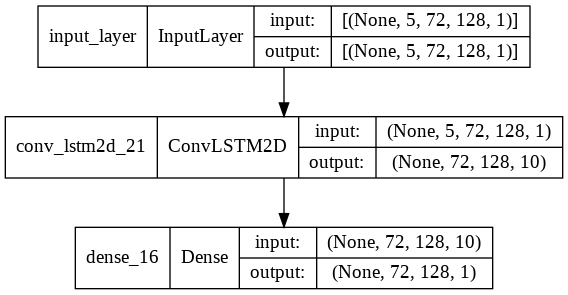

In [151]:
#build the network

len_conv_window = 5            #how many points in the convolution kernel in both x and y directions
n_conv_units = 10              #how many different convolution kernels h_i 
n_sensors = 1                  #this is now grayscale, so only one channel
n_time_images = predict_length
n_batch = 1

#this time we will use the standard Keras interface.  each layer is linked to the one below programmatically
input_layer = Input(shape=(n_time_images, image_height, image_width, n_sensors), name='input_layer')
#convLSTM2D has n_conv_units outputs for each pixel in the image.  padding="same" means output image is same size as input
# channels_last data format says this was in the format height, width channels (not channels, height, width)).  
time_space_layer = ConvLSTM2D(filters=n_conv_units, kernel_size=(5,5), data_format='channels_last', 
                              padding='same', return_sequences=False, activation='sigmoid')(input_layer)
#dense layer takes all n_conv_units values at each pixel and combines to a single value to match the output image
top_layer = Dense(units=1, activation='linear')(time_space_layer)
output_layer = top_layer

model1 = Model(inputs = input_layer, outputs = output_layer, name ='model1')  #have to explicitly tell it the inputs and outputs
model1.compile(optimizer='adam', loss='mse')
model1.summary()
plot_model(model1, show_shapes = True, show_layer_names = True)


Epoch 1/5
1648/1648 [==============================] - 969s 586ms/step - loss: 0.0199 - val_loss: 0.0149
Epoch 2/5
1648/1648 [==============================] - 990s 601ms/step - loss: 0.0137 - val_loss: 0.0132
Epoch 3/5
1648/1648 [==============================] - 988s 599ms/step - loss: 0.0129 - val_loss: 0.0129
Epoch 4/5
1648/1648 [==============================] - 991s 601ms/step - loss: 0.0128 - val_loss: 0.0127
Epoch 5/5
1648/1648 [==============================] - 986s 598ms/step - loss: 0.0127 - val_loss: 0.0127


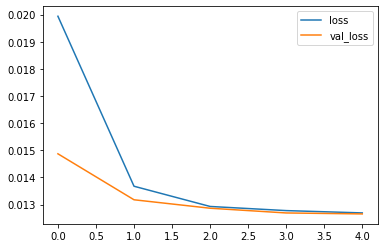

In [152]:
#note that fitting is very slow here.  LSTM() is not fast because there are many parameters.
model1.fit_generator(training_gen1, 
          epochs=5,
          validation_data=validation_gen1,
          callbacks=[early_stop])
losses = pd.DataFrame(model1.history.history)
losses.plot()

In [153]:
output_frames = model1.predict(validation_gen1)


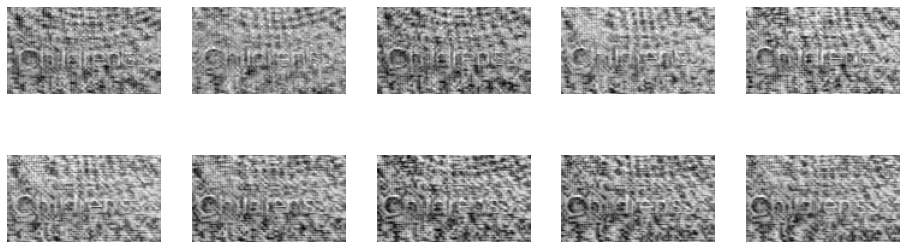

In [178]:
plt.figure(figsize=(16,5))
for n in range(1,11):
  ax = plt.subplot(2,5,n)
  plt.imshow(output_frames[n+20].reshape(image_height, image_width), cmap=plt.get_cmap('gray'));
  ax.axis('off')

#Model2: Optic Flow prediction with LSTM

Now we are going to go back and do the optic flow prediction we did at the last lesson.  We use the same base layer to do the ConvLSTM2D in order to look at the local dynamics of the image.  But this time we are going to train the outputs separately to recognize horizontal and vertical flow.

Instead of concatenating two frames in order to look at time, we will use a ConvLSTM2D layer to create a local estimator of optic flow.  Then we will use average pooling (with a nonlinear "sandwiched" layer between two averaging layers) to combine the optic flow over most of the image.  Finally we flatten, separate the data into two streams, and train a separate 3-layer dense network for the horizontal and vertical components of optic flow.

In [10]:
#here we will use the desired_output (horizontal, vertical components of movement from the gyro)
predict_length = 5      #because LSTM will use this sequence
batch_size = 1
training_set_size = np.int(0.9 * nTimes)
test_set_size = nTimes - training_set_size
gen2 = TimeseriesGenerator(frames_list, desired_output, length = predict_length, batch_size=batch_size)
training_gen2 = TimeseriesGenerator(frames_list[:training_set_size], desired_output[:training_set_size,:], length = predict_length, batch_size=batch_size)
validation_gen2 = TimeseriesGenerator(frames_list[:-test_set_size], desired_output[:-test_set_size,:], length = predict_length, batch_size=batch_size)
early_stop = EarlyStopping(monitor='val_loss',patience=2)

#note the shape of the output:  (batch_size, predict_length, height, width, colorchannels)
gen2[100][0].shape

(1, 5, 72, 128)

Model: "model2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 5, 72, 128,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv_lstm2d (ConvLSTM2D)       (None, 72, 128, 4)   736         ['input_layer[0][0]']            
                                                                                                  
 average_pooling2d (AveragePool  (None, 8, 14, 4)    0           ['conv_lstm2d[0][0]']            
 ing2D)                                                                                           
                                                                                             

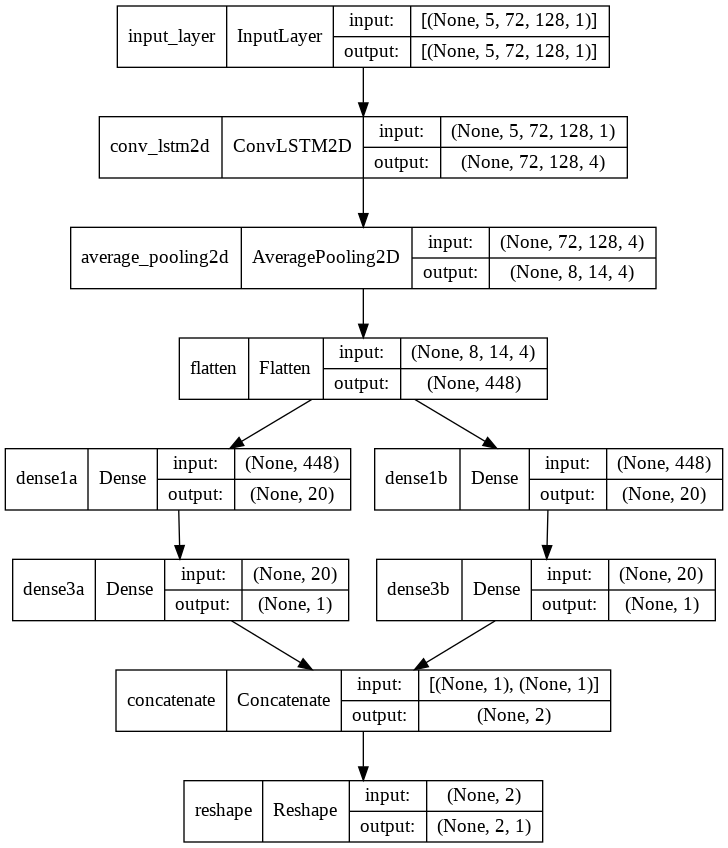

In [11]:
#build the network len_conv_window = 5            #how many points in the convolution kernel in both x and y directions
n_conv_units = 4              #how many different convolution kernels h_i 
n_dense_units = 20
n_sensors = 1                  #this is now grayscale, so only one channel
n_time_images = predict_length
n_batch = 1

#this time we will use the standard Keras interface.  each layer is linked to the one below programmatically
input_layer = Input(shape=(n_time_images, image_height, image_width, n_sensors), name='input_layer')
#convLSTM2D has n_conv_units outputs for each pixel in the image.  padding="same" means output image is same size as input
# channels_last data format says this was in the format height, width channels (not channels, height, width)).  
time_space_layer = ConvLSTM2D(filters=n_conv_units, kernel_size=(3,3), data_format='channels_last', 
                              padding='same', return_sequences=False, activation='linear')(input_layer)
average_layer = AveragePooling2D(pool_size=(9,9), padding = "valid", data_format = 'channels_last')(time_space_layer)
#sandwich_layer = Dense(n_conv_units, activation = 'sigmoid', name='sandwich')(average_layer)
#average_layer2 = AveragePooling2D(pool_size=(3,3), padding = "valid", data_format = 'channels_last')(sandwich_layer)
flat_layer = Flatten()(average_layer)

#split into two parallel streams
dense1a = Dense(units=n_dense_units, activation='sigmoid', name='dense1a')(flat_layer)
dense1b = Dense(units=n_dense_units, activation='sigmoid', name='dense1b')(flat_layer)
#dense2a = Dense(units=n_dense_units2, activation='sigmoid', name='dense2a')(dense1a)
#dense2b = Dense(units=n_dense_units2, activation='sigmoid', name='dense2b')(dense1b)
dense3a = Dense(units=1, activation='linear', name='dense3a')(dense1a)
dense3b = Dense(units=1, activation='linear', name='dense3b')(dense1b)
concat = Concatenate(axis=1)([dense3a, dense3b])   # put the two streams back together so the training data will work as a numpy array
reshape = Reshape(target_shape=(2,1))(concat)
output_layer = reshape  #the output is the result of the two streams

model2 = Model(inputs = input_layer, outputs = output_layer, name ='model2')  #have to explicitly tell it the inputs and outputs
model2.compile(optimizer='adam', loss='mse')
model2.summary()
plot_model(model2, show_shapes = True, show_layer_names = True)


Epoch 1/2
1648/1648 [==============================] - 383s 228ms/step - loss: 0.9664 - val_loss: 0.9668
Epoch 2/2
1648/1648 [==============================] - 364s 221ms/step - loss: 0.9440 - val_loss: 0.8417


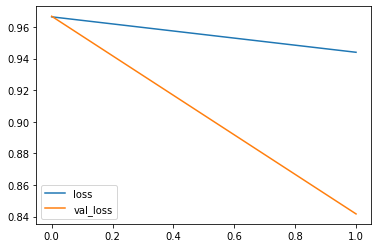

In [12]:
model2.fit(training_gen2, 
          epochs=2,
          validation_data=validation_gen2,
          callbacks=[early_stop])
losses = pd.DataFrame(model2.history.history)
losses.plot()

In [13]:
predicted_output = model2.predict(gen2)

In [29]:
#po = np.asarray(predicted_output).reshape(len(predicted_output),2)
po = np.asarray(predicted_output[:,:,0])
dfPredict = pd.DataFrame(data=po)
nPredict,_  = dfPredict.shape

In [30]:
dfPredict  

,0,1
0,0.038481,0.142987
1,0.077185,0.153320
2,0.116005,0.153496
3,0.159826,0.138944
4,0.190410,0.118943
...,...,...
1827,0.025861,-0.016992
1828,-0.002273,-0.023218
1829,-0.023119,-0.020755
1830,-0.036307,-0.015697


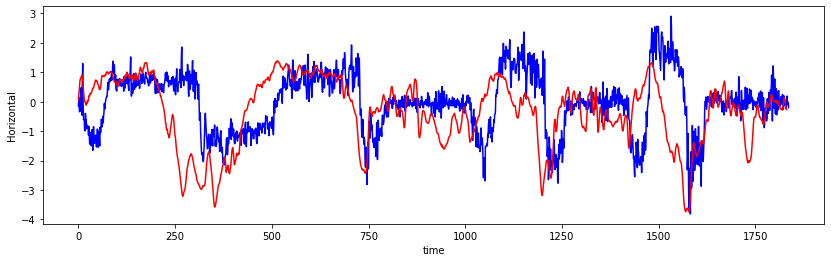

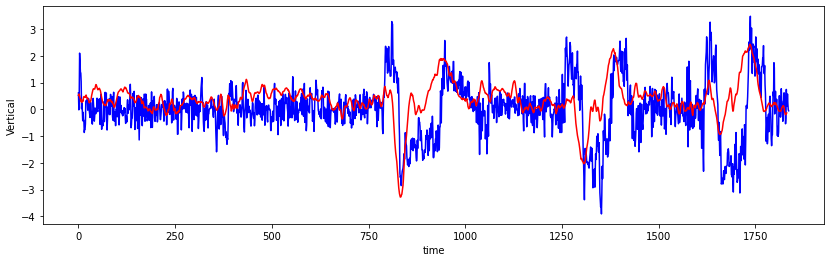

In [31]:
predict = dfPredict.values   #do not have to do ML or MMSE calculation here
predict -= predict.mean()
predict /= predict.std()    #should not have to do this

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(desired_output[:,0],'b')  #compare one column at a time
plt.plot(predict[:,0],'r')
plt.ylabel('Horizontal')
plt.xlabel('time');

plt.figure(figsize=(14,4),linewidth=.1)
plt.plot(desired_output[:,1],'b')  #compare one column at a time
plt.plot(predict[:,1],'r')
plt.ylabel('Vertical')
plt.xlabel('time');




In [32]:
rms_error = np.sqrt(np.sum(np.mean(np.square(predict-desired_output[:nPredict,:]))))
print('Scalar output rms_error {}'.format(rms_error));

Scalar output rms_error 1.2133661140485357


The following is a more complex model.  This takes too long to train, so I won't show the results.  But it gives an idea of how you could build a more complex model if needed.

Model: "model2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 5, 72, 128,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv_lstm2d_2 (ConvLSTM2D)     (None, 72, 128, 10)  11040       ['input_layer[0][0]']            
                                                                                                  
 average_pooling2d_3 (AveragePo  (None, 24, 42, 10)  0           ['conv_lstm2d_2[0][0]']          
 oling2D)                                                                                         
                                                                                             

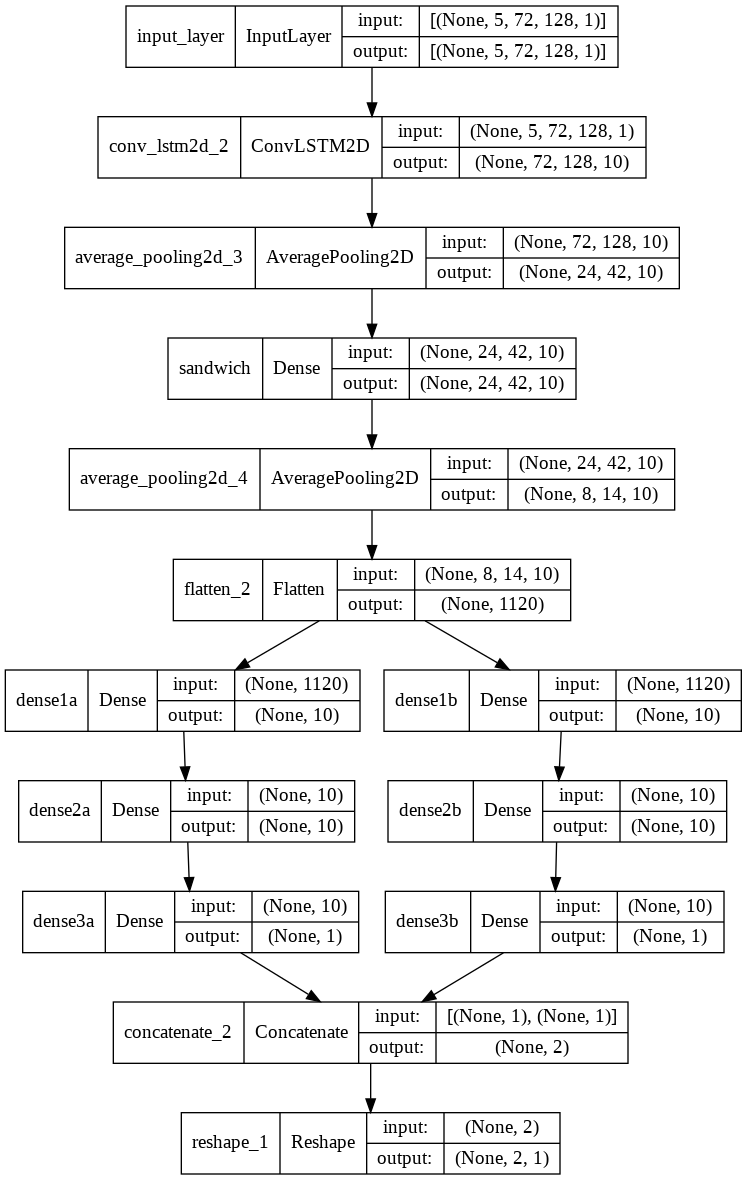

In [34]:
#build the network len_conv_window = 5            #how many points in the convolution kernel in both x and y directions
n_conv_units = 10              #how many different convolution kernels h_i 
n_sensors = 1                  #this is now grayscale, so only one channel
n_time_images = predict_length
n_batch = 1

#this time we will use the standard Keras interface.  each layer is linked to the one below programmatically
input_layer = Input(shape=(n_time_images, image_height, image_width, n_sensors), name='input_layer')
#convLSTM2D has n_conv_units outputs for each pixel in the image.  padding="same" means output image is same size as input
# channels_last data format says this was in the format height, width channels (not channels, height, width)).  
time_space_layer = ConvLSTM2D(filters=n_conv_units, kernel_size=(5,5), data_format='channels_last', 
                              padding='same', return_sequences=False)(input_layer)
average_layer = AveragePooling2D(pool_size=(3,3), padding = "valid", data_format = 'channels_last')(time_space_layer)
sandwich_layer = Dense(n_conv_units, activation = 'sigmoid', name='sandwich')(average_layer)
average_layer2 = AveragePooling2D(pool_size=(3,3), padding = "valid", data_format = 'channels_last')(sandwich_layer)
flat_layer = Flatten()(average_layer2)

#split into two parallel streams
dense1a = Dense(units=n_conv_units, activation='sigmoid', name='dense1a')(flat_layer)
dense1b = Dense(units=n_conv_units, activation='sigmoid', name='dense1b')(flat_layer)
dense2a = Dense(units=n_conv_units, activation='sigmoid', name='dense2a')(dense1a)
dense2b = Dense(units=n_conv_units, activation='sigmoid', name='dense2b')(dense1b)
dense3a = Dense(units=1, activation='linear', name='dense3a')(dense2a)
dense3b = Dense(units=1, activation='linear', name='dense3b')(dense2b)
concat = Concatenate(axis=1)([dense3a, dense3b])   # put the two streams back together so the training data will work as a numpy array
reshape = Reshape(target_shape=(2,1))(concat)

output_layer = reshape  #the output is the result of the two streams

model2 = Model(inputs = input_layer, outputs = output_layer, name ='model2')  #have to explicitly tell it the inputs and outputs
model2.compile(optimizer='adam', loss='mse')
model2.summary()
plot_model(model2, show_shapes = True, show_layer_names = True)


#Homework 6

Use the Gyro data to find times when the image is not moving (or is moving less than a threshold velocity in both horizontal and vertical dimensions).  Train a ConvLSTM2D network (you can use the Model2 structure, or a different structure if you prefer).  The network should predict whether the camera is moving or not.  The network should have two outputs:  one that is 1 when the image is moving, the other is 1 when the image is not moving.  This is a "one-hot" coding for movement.  Note that this is a binary (categorical) one-hot encoded variable so choose the correct output encoding and loss function.  